# <!-- TITLE --> Projet 6 : notebook 1
<!-- AUTHOR : Anthony DAVID -->

# 1 - Preparation of data

## 1.1 - Import python modules

In [4]:
import os, time, sys, pathlib, json, glob
import math, random
import datetime
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import sklearn.metrics

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
from IPython.display import display,Image,Markdown,HTML

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

## 1.2 - Import the dataset, split it into train and validation, and resize the images

Reducing the data to 5 breeds

In [5]:
# import os
# import shutil

# # Dossiers à copier
# selected_breeds = [
#     "n02106550-Rottweiler",
#     "n02107142-Doberman",
#     "n02093428-American_Staffordshire_terrier",
#     "n02105162-malinois",
#     "n02092339-Weimaraner"
# ]

# source_dir = './original_data/Images/'
# destination_dir = './selected_data/images/'

# # Créer le dossier de destination s'il n'existe pas
# os.makedirs(destination_dir, exist_ok=True)

# # Copier les dossiers en enlevant les identifiants
# for breed in selected_breeds:
#     breed_name = breed.split('-', 1)[-1]  # Retirer l'identifiant
#     src_path = os.path.join(source_dir, breed)
#     dst_path = os.path.join(destination_dir, breed_name)
#     shutil.copytree(src_path, dst_path)

# print("Les dossiers ont été copiés et renommés avec succès.")

Les dossiers ont été copiés et renommés avec succès.


Comptage des image par race

In [5]:
import os
from collections import defaultdict

# Dossier de destination contenant les images copiées
destination_dir = './selected_data/images/'

# Initialiser un compteur pour chaque race
image_counts = defaultdict(int)

# Vérifier si le dossier de destination existe
if os.path.exists(destination_dir):
    # Parcourir les dossiers de races
    for breed_dir in os.listdir(destination_dir):
        breed_path = os.path.join(destination_dir, breed_dir)
        # Vérifier si c'est bien un dossier
        if os.path.isdir(breed_path):
            # Compter les fichiers images dans le dossier
            image_counts[breed_dir] = len([img for img in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, img))])
    
    # Afficher les résultats
    for breed, count in image_counts.items():
        print(f"{breed}: {count} images")
else:
    print(f"Le dossier {destination_dir} n'existe pas. Veuillez vérifier le chemin.")

Rottweiler: 152 images
Doberman: 150 images
Weimaraner: 160 images
Staff: 164 images
Malinois: 150 images


In [6]:
data_dir = pathlib.Path('./selected_data/images')
print(os.path.abspath(data_dir))

/Users/anthonydavid/Workspace/Openclassrooms/projet_6/selected_data/images


In [7]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

776


Train-Val-Test splitting

In [12]:
img_height = 224
img_width = 224

# Proportions pour la division des données
test_split = 0.1  # 10% pour le test
validation_split = 0.2  # 20% pour la validation

# Taille du batch (garde la valeur d'origine)
batch_size = image_count

# Étape 1 : Créer le dataset de base pour une division initiale train-test (90% train + val, 10% test)
train_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=test_split,  # 10% pour le test
    subset="training",  # 90% des images pour train + validation
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=test_split,  # 10% pour le test
    subset="validation",  # 10% des images pour le test
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Étape 2 : Diviser train_val_data en train (70%) et validation (20%)
# Calculer la proportion correcte de validation sur le dataset de train+val
train_val_split = validation_split / (1 - test_split)  # ~22.2% pour validation du 90%

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset="training",  # 77.8% des images pour l'entraînement
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=train_val_split,
    subset="validation",  # 22.2% des images pour la validation
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Récupérer les noms des classes
class_names = train_data.class_names
print("Class names:", class_names)
num_classes = len(class_names)
print("Number of classes:", num_classes)

Found 776 files belonging to 5 classes.
Using 699 files for training.
Found 776 files belonging to 5 classes.
Using 77 files for validation.
Found 776 files belonging to 5 classes.
Using 604 files for training.
Found 776 files belonging to 5 classes.
Using 172 files for validation.
Class names: ['Doberman', 'Malinois', 'Rottweiler', 'Staff', 'Weimaraner']
Number of classes: 5


In [14]:
# Extraction de x_train, y_train, x_val, y_val, x_test, y_test

def extract_images_and_labels(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy().astype("uint8"))
        labels.append(label_batch)
    images = tf.concat(images, axis=0).numpy()
    labels = tf.concat(labels, axis=0).numpy()
    return images, labels

x_train, y_train = extract_images_and_labels(train_data)
x_val, y_val = extract_images_and_labels(val_data)
x_test, y_test = extract_images_and_labels(test_data)

# Calcul du nombre total d'images
total_images = x_train.shape[0] + x_val.shape[0] + x_test.shape[0]

# Afficher les tailles et pourcentages des ensembles
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}, ({(x_train.shape[0] / total_images) * 100:.2f}%)")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}, ({(x_val.shape[0] / total_images) * 100:.2f}%)")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}, ({(x_test.shape[0] / total_images) * 100:.2f}%)")

x_train: (604, 224, 224, 3), y_train: (604,), (70.81%)
x_val: (172, 224, 224, 3), y_val: (172,), (20.16%)
x_test: (77, 224, 224, 3), y_test: (77,), (9.03%)


2024-10-05 17:33:18.166452: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 1.3 - Visualizing some resized images

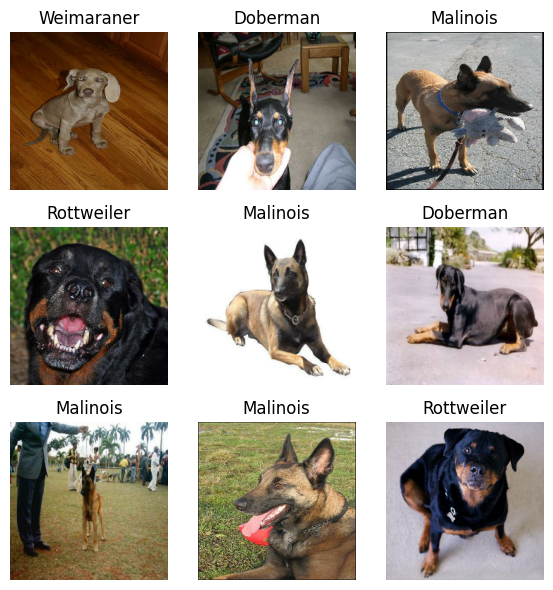

In [16]:
# Create a figure and axis for the grid of images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5)

y_train_strings = [class_names[label] for label in y_train]

# Generate and plot the images in a loop
for i in range(9):
    # Generate a random image
    random_label = random.choice(range(len(x_train)))
    image = x_train[random_label]
    name = y_train_strings[random_label]
    
    # Get the current axis and plot the image
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(name)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

## 1.4 - Create different type of images and visualize the resulting data

Here we use the following type of images : 

- RGB : Image en couleur sans modifications.
- RGB-HE : Image en couleur avec amélioration du contraste.
- L : Image en niveaux de gris.
- L-HE : Image en niveaux de gris avec amélioration du contraste.
- L-LHE : Image en niveaux de gris avec amélioration locale du contraste.
- L-CLAHE : Image en niveaux de gris avec amélioration adaptative et limitée du contraste.
- BW : Image en noir et blanc (binaire).

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

In [17]:
def images_enhancement(images, width=img_width, height=img_height, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float64
    args:
        images :         images list
        width,height :   new images size
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE | BW
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1, 'BW':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))


        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)

        if mode=='BW':
            gray_image = color.rgb2gray(img)
            threshold_value = 0.5  # Adjust this threshold value as needed
            img = np.where(gray_image < threshold_value, 1, 0)

        # ---- Add image in list of list
        out.append(img)

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

### 1.4.1 - Get an idea of the different recipes

dataset : RGB  shape=(16, 224, 224, 3)


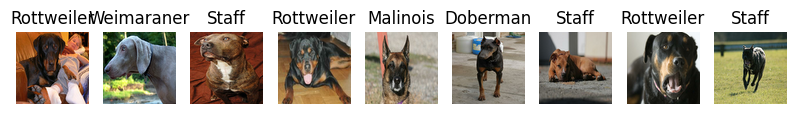

dataset : RGB-HE  shape=(16, 224, 224, 3)


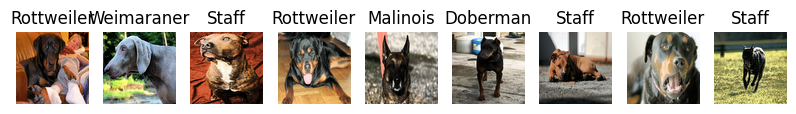

dataset : L  shape=(16, 224, 224, 1)


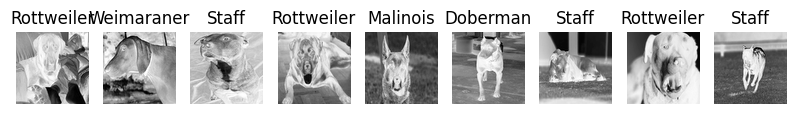

dataset : L-HE  shape=(16, 224, 224, 1)


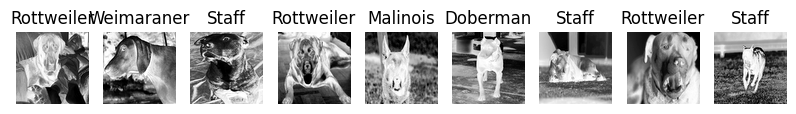

dataset : L-LHE  shape=(16, 224, 224, 1)


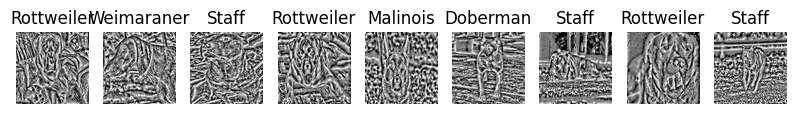

dataset : L-CLAHE  shape=(16, 224, 224, 1)


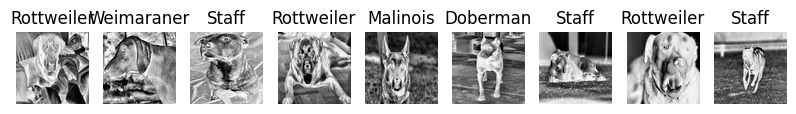

dataset : BW  shape=(16, 224, 224, 1)


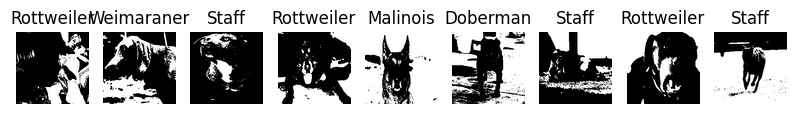

In [18]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]
y_samples_strings = [class_names[label] for label in y_samples]

datasets  = {}

datasets['RGB']      = images_enhancement(x_samples, mode='RGB')
datasets['RGB-HE']   = images_enhancement(x_samples, mode='RGB-HE')
datasets['L']        = images_enhancement(x_samples, mode='L')
datasets['L-HE']     = images_enhancement(x_samples, mode='L-HE')
datasets['L-LHE']    = images_enhancement(x_samples, mode='L-LHE')
datasets['L-CLAHE']  = images_enhancement(x_samples, mode='L-CLAHE')
datasets['BW']       = images_enhancement(x_samples, mode='BW')


# Generate and plot the images in a loop
for k, d in datasets.items():
    # Create a figure and axis for the grid of images
    fig, axes = plt.subplots(1, 9, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.5)

    print("dataset : {}  shape={}".format(k, d.shape))

    for i in range(9):
        image = d[i]
        name = y_samples_strings[i]
        
        # Get the current axis and plot the image
        ax = axes[i % 9]
        ax.imshow(image, cmap='binary', interpolation='lanczos')
        ax.set_title(name)
        ax.axis('off')
        
    # Display the grid of images
    plt.tight_layout()
    plt.show()

## 1.5 - Save the new datasets

A function to save a dataset

In [19]:
# Fonction pour sauvegarder les ensembles de données
def save_h5_dataset(x_train, y_train, x_val, y_val, x_test, y_test, filename):
    # ---- Créer le fichier h5
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_val", data=x_val)
        f.create_dataset("y_val", data=y_val)
        f.create_dataset("x_test", data=x_test)
        f.create_dataset("y_test", data=y_test)
        
    # ---- Affichage de la taille du fichier
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

In [21]:
output_dir = './data'

In [22]:
n_train = int(len(x_train))
n_val = int(len(x_val))
n_test = int(len(x_test))

# Afficher les paramètres
display(Markdown(f"<br>**{'Parameters'}**"))
print(f'x_train length is : {n_train}')
print(f'x_val length is   : {n_val}')
print(f'x_test length is  : {n_test}')
print(f'output dir is     : {output_dir}\n')

display(Markdown(f"<br>**{'Running...'}**"))

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_dir, mode=0o750, exist_ok=True)

# Sauvegarder chaque type de transformation
for m in ['RGB', 'RGB-HE', 'L', 'L-HE', 'L-LHE', 'L-CLAHE', 'BW']:
    # ---- Nom de fichier pour chaque type de transformation
    filename = f'{output_dir}/set-{m}.h5'
    display(Markdown(f"<br>**{filename}**"))
    
    # ---- Amélioration des images pour chaque ensemble (train, val, test)
    x_train_new = images_enhancement(x_train, mode=m)
    x_val_new = images_enhancement(x_val, mode=m)
    x_test_new  = images_enhancement(x_test, mode=m)
        
    # ---- Sauvegarder le dataset transformé
    save_h5_dataset(x_train_new, y_train, x_val_new, y_val, x_test_new, y_test, filename)

display(Markdown(f"<br>**{'Done'}**"))

# Libérer la mémoire
x_train_new, x_val_new, x_test_new = 0, 0, 0

<br>**Parameters**

x_train length is : 604
x_val length is   : 172
x_test length is  : 77
output dir is     : ./data



<br>**Running...**

<br>**./data/set-RGB.h5**

Dataset : ./data/set-RGB.h5         shape : (604, 224, 224, 3)     size :  979.6 Mo   (saved)


<br>**./data/set-RGB-HE.h5**

Dataset : ./data/set-RGB-HE.h5      shape : (604, 224, 224, 3)     size :  979.6 Mo   (saved)


<br>**./data/set-L.h5**

Dataset : ./data/set-L.h5           shape : (604, 224, 224, 1)     size :  326.5 Mo   (saved)


<br>**./data/set-L-HE.h5**

Dataset : ./data/set-L-HE.h5        shape : (604, 224, 224, 1)     size :  326.5 Mo   (saved)


<br>**./data/set-L-LHE.h5**

Dataset : ./data/set-L-LHE.h5       shape : (604, 224, 224, 1)     size :  326.5 Mo   (saved)


<br>**./data/set-L-CLAHE.h5**

Dataset : ./data/set-L-CLAHE.h5     shape : (604, 224, 224, 1)     size :  326.5 Mo   (saved)


<br>**./data/set-BW.h5**

Dataset : ./data/set-BW.h5          shape : (604, 224, 224, 1)     size :  326.5 Mo   (saved)


<br>**Done**

### 1.5.1 - Reload data to be sure

dataset loaded from h5 file.


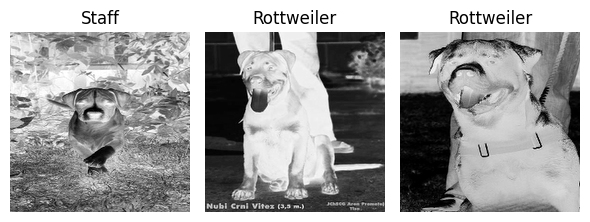

In [23]:
dataset='set-L'

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    y_tmp_strings = [class_names[label] for label in y_tmp]
    print("dataset loaded from h5 file.")

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(1, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5)

# Generate and plot the images in a loop
for i in range(9):
    # Generate a random image
    random_label = random.choice(range(len(x_tmp)))
    image = x_tmp[random_label]
    name = y_tmp_strings[random_label]
    
    # Get the current axis and plot the image
    ax = axes[i % 3]
    ax.imshow(image, cmap='binary', interpolation='lanczos')
    ax.set_title(name)
    ax.axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

x_tmp, y_tmp=0,0